In [1]:
from pipeline.Pipeline import Load
import pandas as pd


load_df = Load()

final_df = load_df.load_restaraunts() 


from datetime import datetime


import pandas as pd
current_date = datetime.now()
dia = current_date.day
month = current_date.month
year = current_date.year
hour = current_date.hour
min = current_date.minute
csv_name = f'dataframe{dia}-{month}-{year}AT{hour}:{min}.csv'

#final_df = pd.read_csv('dataframe2-12-2024AT21:41.csv')
df =final_df
df.to_csv(csv_name,index=True)


df.columns




Index(['restaurant_id', 'fantasy_name', 'has_club', 'has_ifood',
       'is_multistore_related', 'has_fiscal', 'only_delivery', 'has_stone',
       'sessions_count', 'mrr', 'created_at', 'deleted_at', 'survival_days',
       'is_deleted', 'total_users', 'soma_ult_sem', 'soma_sem_anterior',
       'soma_2_sem_anteriores', 'variance_x', 'std_dev_x', 'comandas_ult_sem',
       'comandas_sem_anterior', 'comandas_2_sem_anteriores', 'variance_y',
       'std_dev_y', 'average_table_session'],
      dtype='object')

In [2]:


# Filtrar os dados onde is_deleted == 0
restaurantes_nao_deletados = final_df[final_df['is_deleted'] == 0]

# Selecionar 200 amostras aleatórias
amostras_selecionadas = restaurantes_nao_deletados.sample(n=100, random_state=54)

# Salvar essas amostras em um CSV, se necessário
amostras_selecionadas.to_csv('amostras_teste.csv', index=False)

print(f"Número de amostras selecionadas: {len(amostras_selecionadas)}")

final_df = final_df.drop(amostras_selecionadas.index)

Número de amostras selecionadas: 100


Número de outliers (survival_days): 77


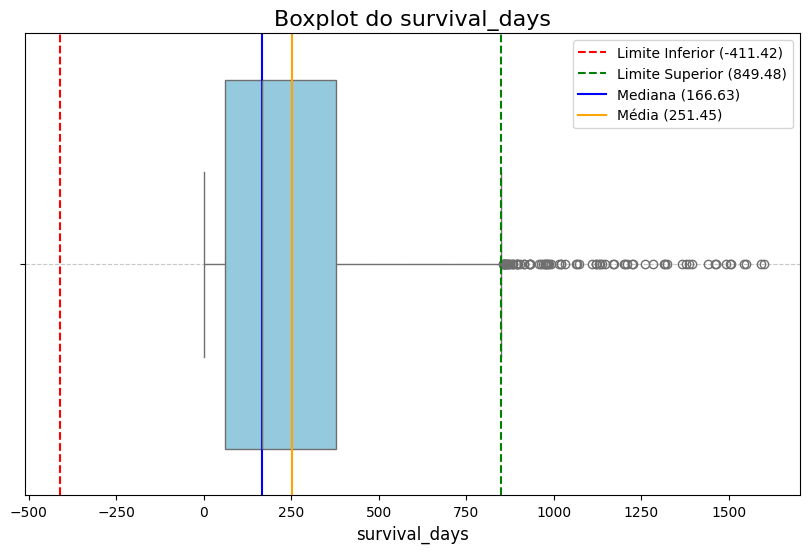

In [4]:


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Dados de mrr
survival_days_data = final_df['survival_days'].fillna(0).astype(float)

# Cálculos de estatísticas
q1 = np.percentile(survival_days_data, 25)
q3 = np.percentile(survival_days_data, 75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr
outliers = final_df[(final_df['survival_days'].astype(float) < limite_inferior) | (final_df['survival_days'].astype(float) > limite_superior)]

print(f"Número de outliers (survival_days): {len(outliers)}")
# Plot do boxplot usando seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x=survival_days_data, color='skyblue')

# Adicionando anotações sobre limites
plt.axvline(x=limite_inferior, color='red', linestyle='--', label=f"Limite Inferior ({limite_inferior:.2f})")
plt.axvline(x=limite_superior, color='green', linestyle='--', label=f"Limite Superior ({limite_superior:.2f})")
plt.axvline(x=np.median(survival_days_data), color='blue', linestyle='-', label=f"Mediana ({np.median(survival_days_data):.2f})")
plt.axvline(x=np.mean(survival_days_data), color='orange', linestyle='-', label=f"Média ({np.mean(survival_days_data):.2f})")

# Configuração do gráfico
plt.title("Boxplot do survival_days", fontsize=16)
plt.xlabel("survival_days", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [5]:

from datetime import datetime


import pandas as pd
current_date = datetime.now()
dia = current_date.day
month = current_date.month
year = current_date.year
hour = current_date.hour
min = current_date.minute


df = pd.DataFrame(final_df)


df.columns


Index(['restaurant_id', 'fantasy_name', 'has_club', 'has_ifood',
       'is_multistore_related', 'has_fiscal', 'only_delivery', 'has_stone',
       'sessions_count', 'mrr', 'created_at', 'deleted_at', 'survival_days',
       'is_deleted', 'total_users', 'soma_ult_sem', 'soma_sem_anterior',
       'soma_2_sem_anteriores', 'variance_x', 'std_dev_x', 'comandas_ult_sem',
       'comandas_sem_anterior', 'comandas_2_sem_anteriores', 'variance_y',
       'std_dev_y', 'average_table_session'],
      dtype='object')

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer



In [17]:


features_to_impute = [
 'has_club', 'has_ifood',
       'is_multistore_related', 'has_fiscal', 'only_delivery',
       'sessions_count', 'mrr', 'total_users', 'soma_ult_sem', 'soma_sem_anterior',
       'soma_2_sem_anteriores', 'variance_x', 'std_dev_x', 'comandas_ult_sem',
       'comandas_sem_anterior', 'comandas_2_sem_anteriores', 'variance_y',
       'std_dev_y', 'average_table_session'
]
missing_values = df[features_to_impute].isnull().sum()

missing_values



has_club                        0
has_ifood                       0
is_multistore_related           0
has_fiscal                      0
only_delivery                   0
sessions_count                  0
mrr                          1150
total_users                     0
soma_ult_sem                  486
soma_sem_anterior             486
soma_2_sem_anteriores         486
variance_x                    486
std_dev_x                     486
comandas_ult_sem              486
comandas_sem_anterior         486
comandas_2_sem_anteriores     486
variance_y                    486
std_dev_y                     486
average_table_session        1054
dtype: int64

      restaurant_id                        fantasy_name  has_club  has_ifood  \
10               13                           Top Sushi         1          1   
112             129                      Five Sport Bar         0          0   
115             132                      Five Sport Bar         0          0   
144             161                     Foodhall Garden         1          0   
1579          28518           Five Sport Bar - Paralela         1          1   
1617          29640            Five Sport Bar - Vitória         1          1   
1618          29641                    Five Sport - VVL         1          1   
1802          35646                Five Sports - Maceió         1          1   
1803          35679                Five Sport - Itabuna         1          1   
1840          36801        Five Sport - Parque Shopping         1          1   
1841          36834             Five Sport - Piracicaba         1          1   
2154          46833                     

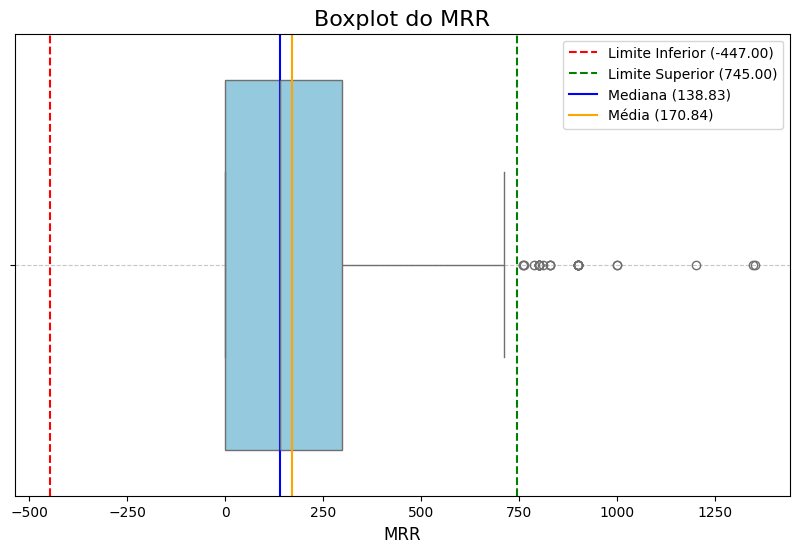

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Dados de mrr
mrr_data = final_df['mrr'].fillna(0).astype(float)

# Cálculos de estatísticas
q1 = np.percentile(mrr_data, 25)
q3 = np.percentile(mrr_data, 75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr
outliers = final_df[(final_df['mrr'].astype(float) < limite_inferior) | (final_df['mrr'].astype(float) > limite_superior)]
print(outliers)
print(f"Número de outliers (MRR): {len(outliers)}")
# Plot do boxplot usando seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x=mrr_data, color='skyblue')

# Adicionando anotações sobre limites
plt.axvline(x=limite_inferior, color='red', linestyle='--', label=f"Limite Inferior ({limite_inferior:.2f})")
plt.axvline(x=limite_superior, color='green', linestyle='--', label=f"Limite Superior ({limite_superior:.2f})")
plt.axvline(x=np.median(mrr_data), color='blue', linestyle='-', label=f"Mediana ({np.median(mrr_data):.2f})")
plt.axvline(x=np.mean(mrr_data), color='orange', linestyle='-', label=f"Média ({np.mean(mrr_data):.2f})")

# Configuração do gráfico
plt.title("Boxplot do MRR", fontsize=16)
plt.xlabel("MRR", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


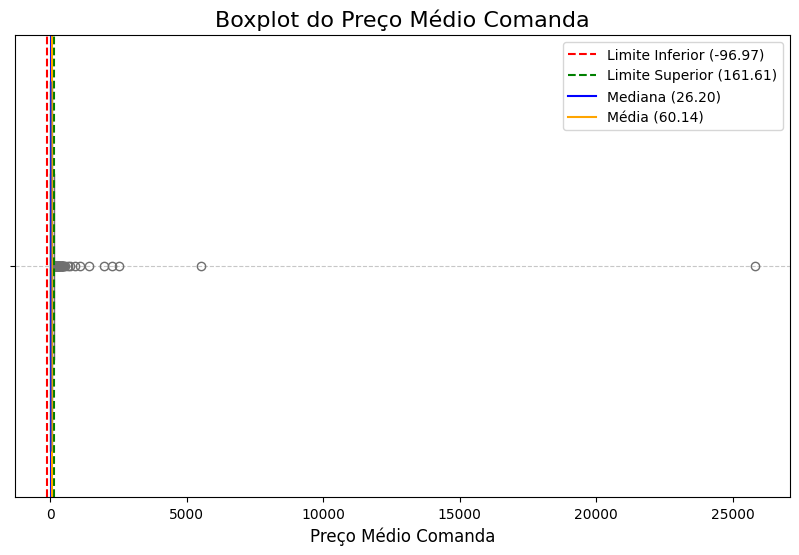

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Dados de average_table_session
average_table_price = final_df['average_table_session'].fillna(0).astype(float)

# Cálculos de estatísticas
q1 = np.percentile(average_table_price, 25)
q3 = np.percentile(average_table_price, 75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr
outliers = final_df[(final_df['average_table_session'].astype(float) < limite_inferior) | (final_df['average_table_session'].astype(float) > limite_superior)]

# Plot do boxplot usando seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x=average_table_price, color='skyblue')

# Adicionando anotações sobre limites
plt.axvline(x=limite_inferior, color='red', linestyle='--', label=f"Limite Inferior ({limite_inferior:.2f})")
plt.axvline(x=limite_superior, color='green', linestyle='--', label=f"Limite Superior ({limite_superior:.2f})")
plt.axvline(x=np.median(average_table_price), color='blue', linestyle='-', label=f"Mediana ({np.median(average_table_price):.2f})")
plt.axvline(x=np.mean(average_table_price), color='orange', linestyle='-', label=f"Média ({np.mean(average_table_price):.2f})")

# Configuração do gráfico
plt.title("Boxplot do Preço Médio Comanda", fontsize=16)
plt.xlabel("Preço Médio Comanda", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [20]:
imputer = SimpleImputer()

X_to_impute = df[features_to_impute]
X_imputed = imputer.fit_transform(X_to_impute)




y_time = df['survival_days'].astype(float)  # Tempo até o evento
y_event = df['is_deleted'].astype(bool)    # Churn ocorreu ou não

scaler = StandardScaler()
X_scaled=scaler.fit_transform(X_imputed)

In [21]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split

In [23]:



y = Surv.from_arrays(event=y_event, time=y_time)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,  
    y,        
    test_size=0.5,  
    random_state=42,  
    stratify=y_event 
)







rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=20,max_depth=10, random_state=42)


rsf.fit(X_train, y_train)


c_index_train = rsf.score(X_train, y_train)  # Avaliar no conjunto de treino
c_index_test = rsf.score(X_test, y_test)    # Avaliar no conjunto de teste

print(f"C-Index no conjunto de treino: {c_index_train}")
print(f"C-Index no conjunto de teste: {c_index_test}")



C-Index no conjunto de treino: 0.8673297916357646
C-Index no conjunto de teste: 0.8395922414327323


/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 370, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2145, in _check_response_method
    raise AttributeError(
AttributeError: RandomSurvivalForest has none of the

C-Index médio na validação cruzada: nan


/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 370, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2145, in _check_response_method
    raise AttributeError(
AttributeError: RandomSurvivalForest has none of the

In [24]:
from sklearn.model_selection import KFold
from sksurv.metrics import concordance_index_censored

# Configurar a validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

for train_idx, test_idx in kf.split(X_scaled):
    # Dividir os dados
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Treinar o modelo
    rsf.fit(X_train, y_train)
    
    # Fazer previsões e calcular o C-Index
    surv_preds = rsf.predict_survival_function(X_test)
    c_index = rsf.score(X_test, y_test)
    c_index_scores.append(c_index)4

# Resultado médio da validação cruzada
print(f"C-Index médio: {np.mean(c_index_scores):.4f}")


C-Index médio: 0.8412


In [14]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean
sorted_indices = np.argsort(importances)[::-1]

# Mostrar as características mais importantes
for i in sorted_indices:
    print(f"Feature: {features_to_impute[i]}, Importance: {importances[i]}")


Feature: sessions_count, Importance: 0.1367739336767637
Feature: average_table_session, Importance: 0.01741709595459843
Feature: mrr, Importance: 0.015652767532838785
Feature: is_multistore_related, Importance: 0.008265216982810497
Feature: comandas_ult_sem, Importance: 0.007479705025717309
Feature: variance_y, Importance: 0.006267903655594131
Feature: std_dev_y, Importance: 0.005016521838211952
Feature: soma_ult_sem, Importance: 0.004554250200401011
Feature: total_users, Importance: 0.0035628399570612037
Feature: has_club, Importance: 0.002924855121569958
Feature: comandas_sem_anterior, Importance: 0.0027592369369531466
Feature: variance_x, Importance: 0.002578926010550786
Feature: soma_2_sem_anteriores, Importance: 0.0016244974982358661
Feature: comandas_2_sem_anteriores, Importance: 0.0007560265228976903
Feature: has_ifood, Importance: 0.0004361845248447405
Feature: has_fiscal, Importance: 0.00021529364493939608
Feature: has_stone, Importance: 2.498765609788567e-05
Feature: only_del

In [15]:
from sksurv.metrics import brier_score

import numpy as np

surv_funcs = rsf.predict_survival_function(X_test)


y_test_structured = np.array(

    [(event, time) for event, time in y_test],
    dtype=[("event", bool), ("time", float)]

)



y_train_structured = np.array(

    [(event, time) for event, time in y_train],
    dtype=[("event", bool), ("time", float)]
)

min_test_time = y_test_structured["time"].min()
max_test_time = y_test_structured["time"].max()

time_horizons = np.arange(30, 1500, 90)
surv_probs = np.array([[fn(t) for t in time_horizons] for fn in surv_funcs ])




# Calcular o Brier Score
times, brier_scores = brier_score(y_train_structured, y_test_structured, surv_probs, time_horizons)


print(np.mean(brier_scores))

0.1209017510732128


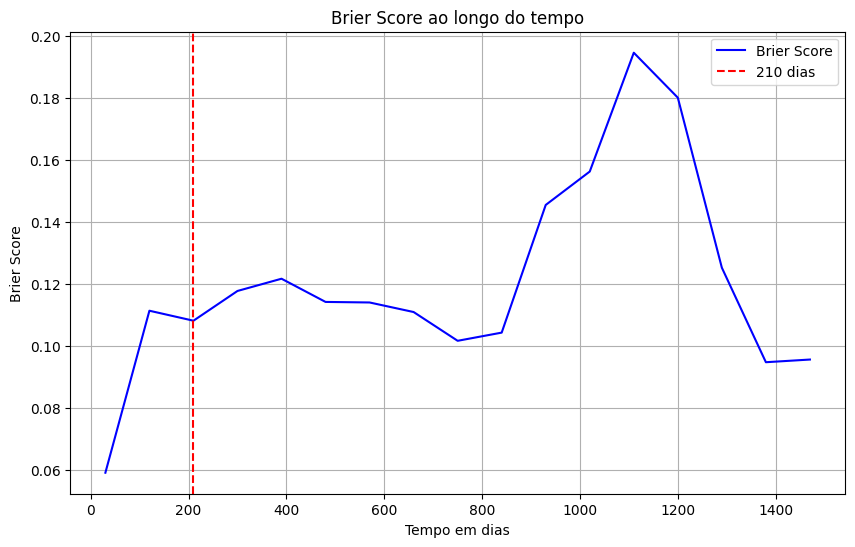

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(times, brier_scores, label="Brier Score", color="blue")
plt.axvline(x=210, color="red", linestyle="--", label="210 dias")
plt.xlabel("Tempo em dias")
plt.ylabel("Brier Score")
plt.title("Brier Score ao longo do tempo")
plt.legend()
plt.grid()
plt.show()


Estatistica Ifood: 79.67351913890586
P-value Ifood: 4.4168086039501555e-19
Estatistica Clube: 54.94672709707398
P-value Clube: 1.2384143726617146e-13
Há uma diferença estatisticamente significativa entre os grupos(CLUBE).
Há uma diferença estatisticamente significativa entre os grupos(IFOOD).


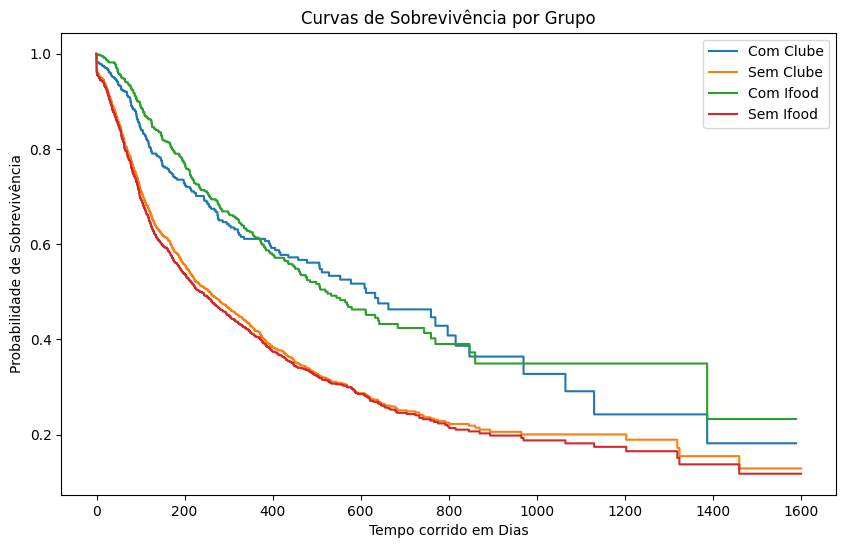

In [16]:
from lifelines.statistics import KaplanMeierFitter,logrank_test

clientes_clube = df[df['has_club']==1]
clientes_sem_clube = df[df['has_club']==0]
clientes_ifood = df[df['has_ifood'] == 1]
clientes_sem_ifood = df[df['has_ifood']==0]

results_clube = logrank_test(clientes_clube['survival_days'].astype(float),
                       clientes_sem_clube['survival_days'].astype(float),
                       event_observed_A=clientes_clube['is_deleted'],
                       event_observed_B=clientes_sem_clube['is_deleted']
                       
                       )

results_ifood = logrank_test(clientes_ifood['survival_days'].astype(float),
                       clientes_sem_ifood['survival_days'].astype(float),
                       event_observed_A=clientes_ifood['is_deleted'],
                       event_observed_B=clientes_sem_ifood['is_deleted'])



print(f'Estatistica Ifood: {results_ifood.test_statistic}')
print(f'P-value Ifood: {results_ifood.p_value}')

print(f'Estatistica Clube: {results_clube.test_statistic}')
print(f'P-value Clube: {results_clube.p_value}')



if results_clube.p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos(CLUBE).")
else:
    print("Não há diferença estatisticamente significativa entre os grupos(CLUBE).")


if results_ifood.p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos(IFOOD).")
else:
    print("Não há diferença estatisticamente significativa entre os grupos(IFOOD).")


kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))


kmf.fit(clientes_clube['survival_days'], event_observed=clientes_clube['is_deleted'], label="Com Clube")
kmf.plot_survival_function(ci_show = False)

kmf.fit(clientes_sem_clube['survival_days'], event_observed=clientes_sem_clube['is_deleted'], label="Sem Clube")
kmf.plot_survival_function(ci_show = False)


kmf.fit(clientes_ifood['survival_days'], event_observed=clientes_ifood['is_deleted'], label="Com Ifood")
kmf.plot_survival_function(ci_show = False)

kmf.fit(clientes_sem_ifood['survival_days'], event_observed=clientes_sem_ifood['is_deleted'], label="Sem Ifood")
kmf.plot_survival_function(ci_show = False)

plt.title("Curvas de Sobrevivência por Grupo")
plt.xlabel("Tempo corrido em Dias")
plt.ylabel("Probabilidade de Sobrevivência")
plt.legend()
plt.show()

  